# Dataset

The dataset is from the [gov.uk website](https://www.gov.uk/guidance/about-the-price-paid-data#download-options).

In [172]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pprint
import calendar

plt.xkcd() # keep life fun

In [1]:
df = pd.read_csv('pp-complete.csv', header=None)

In [2]:
df.columns = [
    'Sale ID',
    'House Price',
    'Date of Transfer',
    'Postcode',
    'Property Type',
    'Old/New',
    'Duration',
    'PAON',
    'SAON',
    'Street',
    'Locality',
    'Town/City',
    'District',
    'County',
    'PPD Type',
    'Record Status'
]

date = 'Date of Transfer'

df[date] = pd.to_datetime(df[date])

In [116]:
# useful generators
def months():
    for m in range(1, 13):
        yield str(m).zfill(2)
        
def years():
    for y in range(1995, 2019):
        yield str(y).zfill(4)
        
days = {
    '01':'31',
    '02':'28',
    '03':'31',
    '04':'30',
    '05':'31',
    '06':'30',
    '07':'31',
    '08':'31',
    '09':'30',
    '10':'31',
    '11':'30',
    '12':'31'
}

# First Look

The file contains data about all sales starting from 1995-01-01 (~23.5M entries):

In [5]:
df['Sale ID'].count()

23648345

There is all sorts of data: house price, address/postcode, old vs. new build... a full key is available [here](https://www.gov.uk/guidance/about-the-price-paid-data#explanations-of-column-headers-in-the-ppd)

In [9]:
df.head(1)

Sale ID  House Price Date of Transfer  \
0  {1BA349E3-2579-40D6-999E-49E2A25D2284}        73450       1995-10-09   

  Postcode Property Type Old/New Duration PAON SAON       Street   Locality  \
0  L26 7XJ             D       Y        F    6  NaN  CATKIN ROAD  LIVERPOOL   

   Town/City  District      County PPD Type Record Status  
0  LIVERPOOL  KNOWSLEY  MERSEYSIDE        A             A

What are the first and last house sales that are recorded in this dataset?

In [54]:
print(df[date].min())
print(df[date].max())

1995-01-01 00:00:00
2018-08-30 00:00:00


## No. of House Sales

The first interesting thing to look at is the answer to the question: 'how many houses have been sold yearly?'.
We're probably suspecting a big drop around 2008, when the housing market collapsed. Did it ever recover? How much?

In [16]:
yearly_sales = dict()
for y in years():
    yearly_sales[y] = df[(df[date] > f'{y}-01-01') & (df[date] < f'{y}-12-31')]['Sale ID'].count()

(0, 1390901.95)

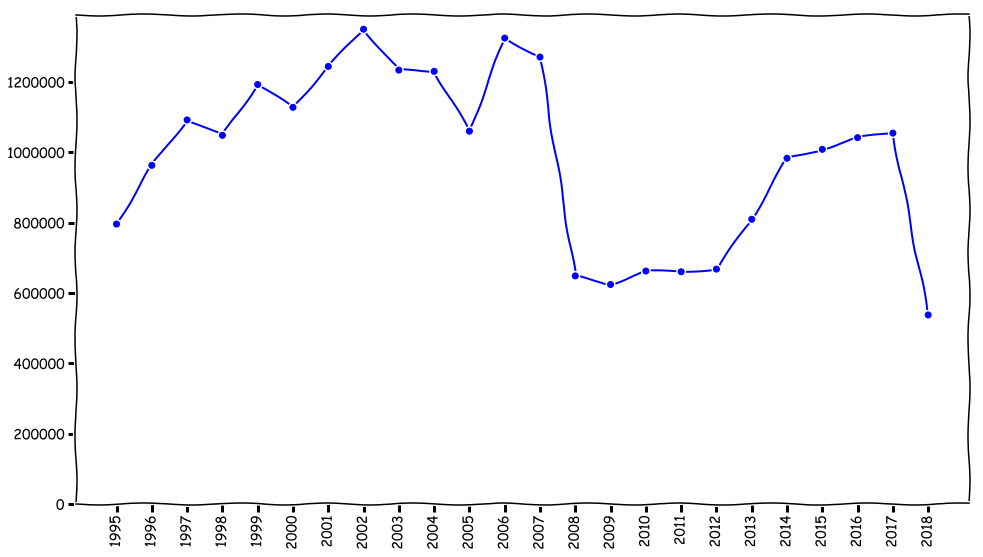

In [168]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111)
ax.plot_date(yearly_sales.keys(), yearly_sales.values(), 'b-o')
ax.set_xticklabels(yearly_sales.keys(), rotation=90)
ax.set_ylim(ymin=0)

In [81]:
monthly_sales = dict()
monthly_median_price = dict()

for y in years():
    for m in months():
        monthly_df = df[(df[date] > f'{y}-{m}-01') & (df[date] < f'{y}-{m}-{days[m]}')]
        monthly_sales[f'{y}-{m}'] = monthly_df['Sale ID'].count()
        monthly_median_price[f'{y}-{m}'] = monthly_df['House Price'].median()

## House Price vs No. of Sold Houses

In [169]:
normalised_sales = dict()
normalised_median_price = dict()

for y in years():
    for m in months():
        normalised_sales[f'{y}-{m}'] = yearly_sales[f'{y}'] / yearly_sales['1995']
        normalised_median_price[f'{y}-{m}'] = monthly_median_price[f'{y}-{m}'] / monthly_median_price['1995-01']

(0, 5.0)

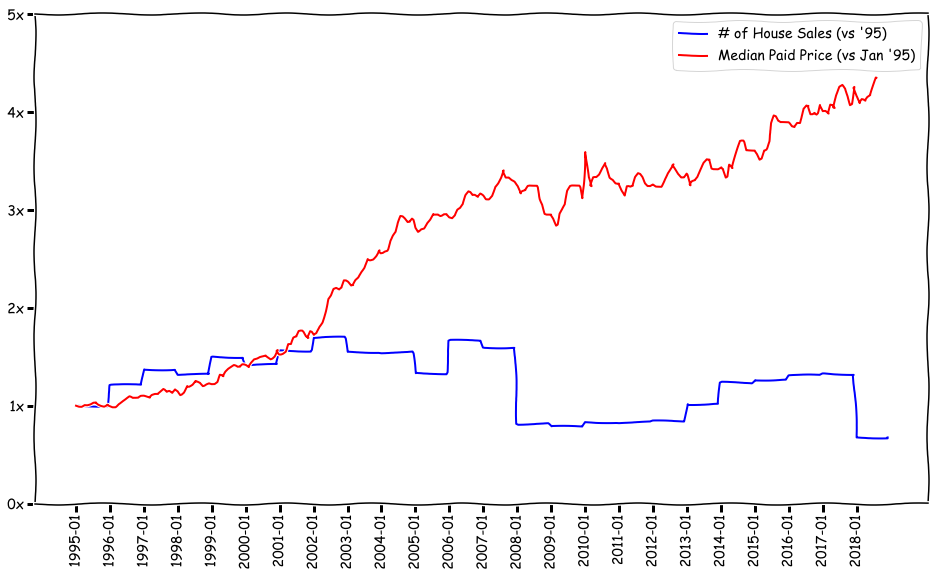

In [171]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111)
ax.grid(b=True, which='both', axis='x')
sales_no, = ax.plot_date(normalised_sales.keys(), normalised_sales.values(), 'b-', label="# of House Sales (vs '95)")
paid_price, = ax.plot_date(normalised_median_price.keys(), normalised_median_price.values(), 'r-', label="Median Paid Price (vs Jan '95)")
ax.legend(handles=[sales_no, paid_price])
ax.set_xticks([f"{y}-01" for y in years()])
ax.set_xticklabels([f"{y}-01" for y in years()], rotation=90)
ax.set_yticks(range(6))
ax.set_yticklabels([f"{n}x" for n in range(6)])
ax.set_ylim(ymin=0)

# New Builds

In [ ]:
normalised_new_builds = dict()
yearly_new_builds = dict()

for y in years():
    yearly_new_builds[f'{y}'] = df[(df[date] > f'{y}-01-01') & (df[date] < f'{y}-12-31') & (df['Old/New'] == 'Y')]['Sale ID'].count()
    normalised_new_builds[f'{y}'] = yearly_new_builds[f'{y}'] / yearly_sales[f'{y}']

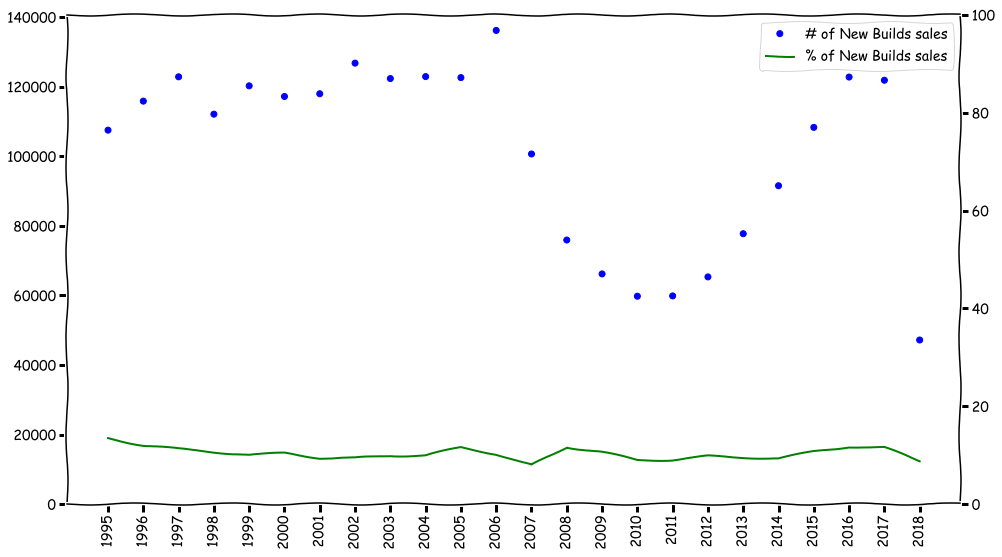

In [120]:
fig = plt.figure(figsize=(16,9))

ax1 = fig.add_subplot(111)

new_builds, = ax1.plot_date(yearly_new_builds.keys(), yearly_new_builds.values(), 'bo', label="# of New Builds sales")
ax1.set_xticks([f"{y}" for y in years()])
ax1.set_xticklabels([f"{y}" for y in years()], rotation=90)
ax1.set_ylim(ymin=0)

ax2 = ax1.twinx()
new_builds_percent, = ax2.plot_date(normalised_new_builds.keys(), [v*100 for v in normalised_new_builds.values()], 'g-', label="% of New Builds sales")
ax2.set_ylim(ymin=0, ymax=100)

ax1.legend(handles=[new_builds, new_builds_percent])

In [152]:
all_houses_by_month_df = pd.DataFrame()
all_houses_by_month_df = all_houses_by_month_df.assign(all=df.groupby(df[date].dt.month)['Sale ID'].count())
all_houses_by_month_df = all_houses_by_month_df.assign(new=df[(df['Old/New'] == 'Y')].groupby(df[date].dt.month)['Sale ID'].count())

[Text(0,0,'Jan'),
 Text(0,0,'Feb'),
 Text(0,0,'Mar'),
 Text(0,0,'Apr'),
 Text(0,0,'May'),
 Text(0,0,'Jun'),
 Text(0,0,'Jul'),
 Text(0,0,'Aug'),
 Text(0,0,'Sep'),
 Text(0,0,'Oct'),
 Text(0,0,'Nov'),
 Text(0,0,'Dec')]

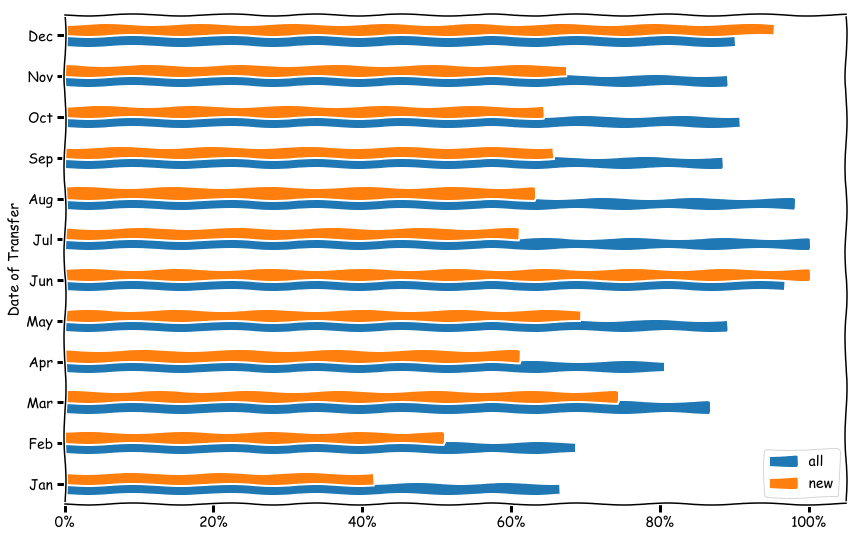

In [173]:
# normalize data
all_houses_by_month_df['all'] /= all_houses_by_month_df['all'].max()
all_houses_by_month_df['new'] /= all_houses_by_month_df['new'].max()

ax = all_houses_by_month_df.plot(figsize=(14,9), kind='barh')
ax.set_xticks([n/10 for n in range(0, 11, 2)])
ax.set_xticklabels([f"{n}%" for n in range(0, 101, 20)])
ax.set_yticklabels([calendar.month_abbr[int(m)] for m in months()])

## Buy-to-Let

In [156]:
normalised_buy_to_let = dict()
yearly_buy_to_let = dict()

for y in years():
    yearly_buy_to_let[f'{y}'] = df[(df[date] > f'{y}-01-01') & (df[date] < f'{y}-12-31') & (df['PPD Type'] != 'A')]['Sale ID'].count()
    normalised_buy_to_let[f'{y}'] = yearly_buy_to_let[f'{y}'] / yearly_sales[f'{y}']

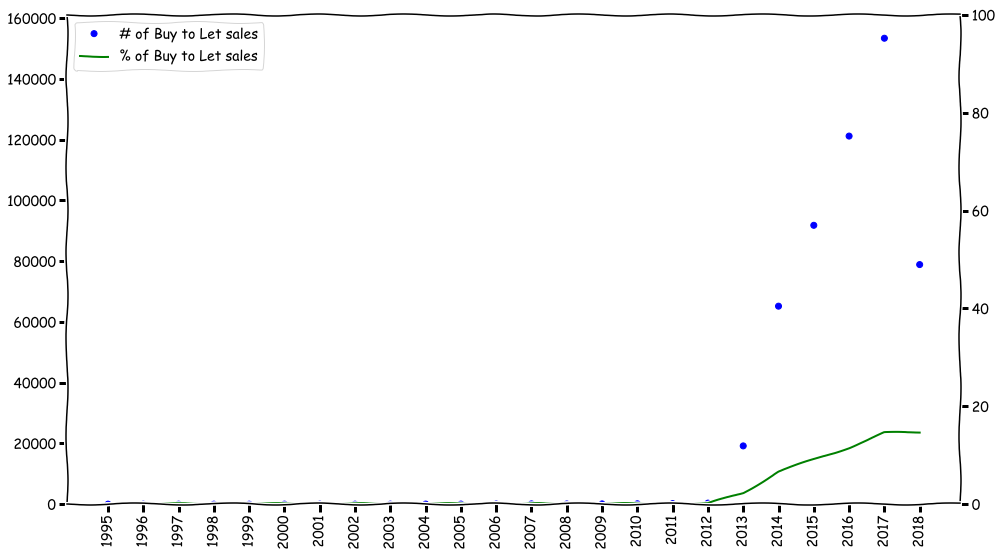

In [121]:
fig = plt.figure(figsize=(16,9))

ax1 = fig.add_subplot(111)
buy_to_let, = ax1.plot_date(yearly_buy_to_let.keys(), yearly_buy_to_let.values(), 'bo', label="# of Buy to Let sales")
ax1.set_xticks([f"{y}" for y in years()])
ax1.set_xticklabels([f"{y}" for y in years()], rotation=90)
ax1.set_ylim(ymin=0)

ax2 = ax1.twinx()
buy_to_let_percent, = ax2.plot_date(normalised_buy_to_let.keys(), [v*100 for v in normalised_buy_to_let.values()], 'g-', label="% of Buy to Let sales")
ax2.set_ylim(ymin=0, ymax=100)

ax1.legend(handles=[buy_to_let, buy_to_let_percent])

In [185]:
yearly_buy_to_let_prices = dict()
yearly_prices = dict()

for y in range(2013, 2018):
    yearly_df = df[(df[date] > f'{y}-01-01') & (df[date] < f'{y}-12-31')]
    yearly_buy_to_let_prices[f'{y}'] =  yearly_df[yearly_df['PPD Type'] != 'A']['House Price'].median()
    yearly_prices[f'{y}'] = yearly_df[yearly_df['PPD Type'] == 'A']['House Price'].median()

(0, 300000.0)

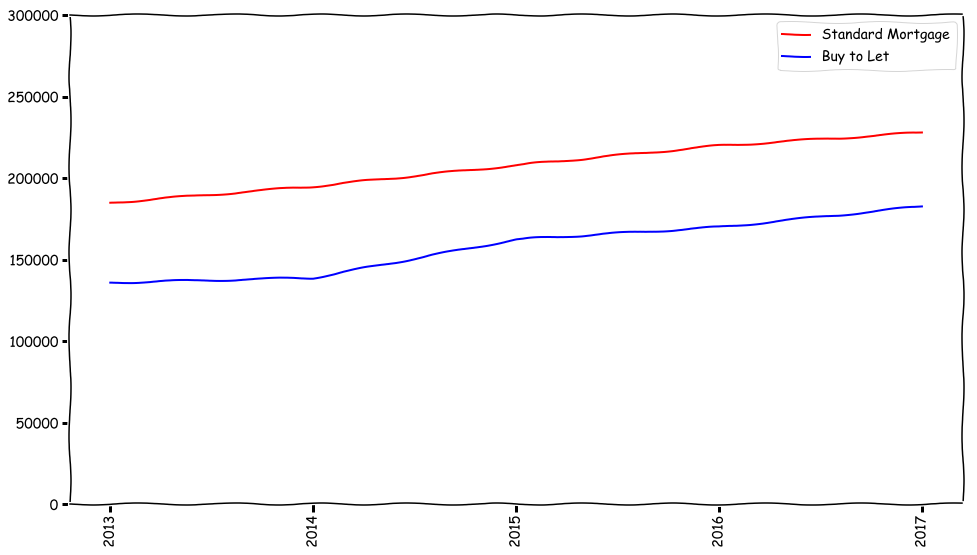

In [186]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111)
ax.grid(b=True, which='both', axis='x')
buy_to_let, = ax.plot_date(yearly_buy_to_let_prices.keys(), yearly_buy_to_let_prices.values(), 'b-', label="Buy to Let")
standard_sales, = ax.plot_date(yearly_prices.keys(), yearly_prices.values(), 'r-', label="Standard Mortgage")
ax.legend(handles=[standard_sales, buy_to_let])
ax.set_xticklabels(yearly_buy_to_let_prices.keys(), rotation=90)
ax.set_yticks(range(0, 300_001, 50_000))
ax.set_ylim(ymin=0)